# Initial Setup and Data Load

In [1]:
%load_ext autoreload
%autoreload 2
import os

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from scipy.stats import norm, skew

import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import category_encoders as ce
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error
from scipy.special import boxcox1p


import string
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH = "../../../data/house_pricing/"

In [4]:
df_train=pd.read_csv(f'{PATH}train.csv')#, index_col='Id')
df_test=pd.read_csv(f'{PATH}test.csv')#, index_col='Id')

### Y (target value) to Log, as stated at Kaggle Evaluation page

In [5]:
# for the purpose of evaluation of current competition
#df_train.SalePrice = np.log1p(df_train.SalePrice)
df_train.SalePrice = np.log1p(df_train.SalePrice)

In [6]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['SalePrice'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
#print(df_train.columns)
#print(df_test.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459



In [7]:
#print(df_train.info())
#df_train.sample(3)
#print(df_test.info())
#df_test.sample(3)

# Dealing with Outliers

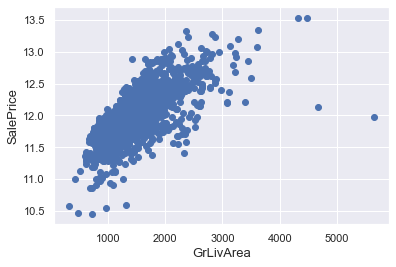

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

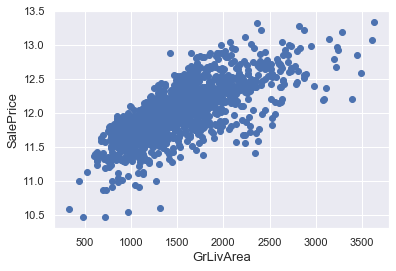

In [9]:
# Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# DataFrame concatination and Y separation

In [10]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

df_all.shape

(2915, 81)

In [11]:
#remember where to divide train and test
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

In [12]:
#Dividing Target column (Y)
y_train_full = df_train.SalePrice.values
df_all.drop(['SalePrice'], axis=1, inplace=True)
df_all.drop('Id',axis=1,inplace=True)

# Dealing with Missing Values

### Create columns to mark originally missed values

In [13]:
def mark_missing (df):
    for col in df.columns:
        if df_all[col].isnull().sum()>0:
            df_all[col+'_missed']=df_all[col].isnull()

In [14]:
mark_missing(df_all)

In [15]:
df_all.shape

(2915, 113)

### Replace Missing

In [16]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
for df in dfs:
    print(format(df.name))
    display_missing(df)
    
    
    
#Check remaining missing values if any 
def display_only_missing(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print(missing_data)

Training Set
Id 0
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1365
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 8
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1451
Fence 1176
MiscFeature 1402
MiscVal 0
M

In [17]:
display_only_missing(df_all)

              Missing Ratio
PoolQC            99.725557
MiscFeature       96.397942
Alley             93.207547
Fence             80.445969
FireplaceQu       48.713551
LotFrontage       16.672384
GarageQual         5.454545
GarageCond         5.454545
GarageFinish       5.454545
GarageYrBlt        5.454545
GarageType         5.385935
BsmtExposure       2.813036
BsmtCond           2.813036
BsmtQual           2.778731
BsmtFinType2       2.744425
BsmtFinType1       2.710120
MasVnrType         0.823328
MasVnrArea         0.789022
MSZoning           0.137221
BsmtFullBath       0.068611
BsmtHalfBath       0.068611
Utilities          0.068611
Functional         0.068611
Electrical         0.034305
BsmtUnfSF          0.034305
Exterior1st        0.034305
Exterior2nd        0.034305
TotalBsmtSF        0.034305
GarageArea         0.034305
GarageCars         0.034305
BsmtFinSF2         0.034305
BsmtFinSF1         0.034305
KitchenQual        0.034305
SaleType           0.034305


### Replace non-missing but "NA", "None", etc values by Data description

##### Replace NA in Object columns

In [18]:
display_only_missing(df_all)

              Missing Ratio
PoolQC            99.725557
MiscFeature       96.397942
Alley             93.207547
Fence             80.445969
FireplaceQu       48.713551
LotFrontage       16.672384
GarageQual         5.454545
GarageCond         5.454545
GarageFinish       5.454545
GarageYrBlt        5.454545
GarageType         5.385935
BsmtExposure       2.813036
BsmtCond           2.813036
BsmtQual           2.778731
BsmtFinType2       2.744425
BsmtFinType1       2.710120
MasVnrType         0.823328
MasVnrArea         0.789022
MSZoning           0.137221
BsmtFullBath       0.068611
BsmtHalfBath       0.068611
Utilities          0.068611
Functional         0.068611
Electrical         0.034305
BsmtUnfSF          0.034305
Exterior1st        0.034305
Exterior2nd        0.034305
TotalBsmtSF        0.034305
GarageArea         0.034305
GarageCars         0.034305
BsmtFinSF2         0.034305
BsmtFinSF1         0.034305
KitchenQual        0.034305
SaleType           0.034305


In [19]:
# fill NA values (not missed) with None - based on data description -  - for non-Numerical (object) Columns
for col in ('Alley','MasVnrType','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond','PoolQC','Fence','MiscFeature'):
    df_all[col] = df_all[col].fillna('None')

##### Replace NA in Numerical columns

In [20]:
display_only_missing(df_all)

              Missing Ratio
LotFrontage       16.672384
GarageYrBlt        5.454545
MasVnrArea         0.789022
MSZoning           0.137221
Utilities          0.068611
BsmtFullBath       0.068611
BsmtHalfBath       0.068611
Functional         0.068611
Exterior1st        0.034305
BsmtFinSF2         0.034305
BsmtUnfSF          0.034305
Electrical         0.034305
GarageArea         0.034305
Exterior2nd        0.034305
TotalBsmtSF        0.034305
GarageCars         0.034305
KitchenQual        0.034305
SaleType           0.034305
BsmtFinSF1         0.034305


In [21]:
#fill NA numerical value with '0' - based on data description of correspondent Object columns - for Numerical Columns
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)

##### Replace NA missing values by most often in column (only for columns with 2 and less NA values, where do not make sense to invest hugely into Analysis)

In [22]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.672384
MSZoning          0.137221
Utilities         0.068611
Functional        0.068611
SaleType          0.034305
KitchenQual       0.034305
Exterior2nd       0.034305
Exterior1st       0.034305
Electrical        0.034305


In [23]:
# Fill missing value in corresponding columns with most frequent value in column
for col in ('Utilities','Functional','SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical'):
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)
    
# Functional : data description says NA means typical
# BTW we just used df_all.Functional.mode() = use most frequent value (as 'Typ' is most frequent value)
#df_all["Functional"] = df_all["Functional"].fillna("Typ")

### Replacing real missing values

##### Dealing with missing values left

In [24]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.672384
MSZoning          0.137221


In [25]:
# Dealing with MSZoning

In [26]:
df_all.MSZoning.isnull().sum()

4

In [27]:
df_all["MSZoning"] = df_all["MSZoning"].fillna("None")

In [28]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.672384


In [29]:
# Dealing with LotFrontage

In [30]:
df_all['LotFrontage'].isnull().sum()

486

In [31]:
def filling_na_with_predictions(df, feature):
    """
    df - DataFrame without target column y. Train+Test DataFrame (df_all)
    feature - feature (column), containing real NA values we will fill

    Assumption:
    All other columns do not have NA values. In case of having we have to impute with some Statistical method (Median, etc)
    We do not do it inside this function
    """

    flag_object=0
    
    if df[feature].isnull().sum()>0:
        ## Store Indexes of rows with NA values (we can just call "_missed" column with True values, to check those indexes as well)
        ## Creating index based on NA values present in column
        na_rows_idxs=df[df[feature].isnull()].index 
            ## Creating index based on NA values being present in original DF column
            #na_rows_idxs=df.index[df[feature+'_missed'] == True].tolist()

        ## For fitting and predictiong - convert DF to dummies DF, ready for ML
        #df=pd.get_dummies(df)
        ## If feature object we cant just dummy all, we shouldn't dummy feature column
        df=pd.concat([ pd.Series(df[feature]), pd.get_dummies(df.drop([feature], axis=1)) ], axis=1)


        ## Splitting DF to Feature_Train_X, Feature_Train_y, Feature_Predict_X:
        ## Feature_Train_X = DF without NA values in "feature_with_NA"column
        ## Feature_Train_y = target values that we have. All values in "feature_with_NA" except NA values
        ## Feature_Predict_X = DF of correcponding to NA values in "feature_with_NA" without target vales (basically because they is equal to NA)
        Feature_Train_X=df.drop(df[df[feature].isnull()].index).drop([feature], axis=1)
        Feature_Train_y=df[feature].drop(df[df[feature].isnull()].index).values
        Feature_Predict_X=df[df[feature].isnull()].drop([feature], axis=1)

        ## If feature is NOT Numerical
        ## Label encoding of y values in case it is not numerical
        if is_string_dtype(df[feature]) or is_categorical_dtype(df[feature]):
            flag_object=1
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            le.fit(Feature_Train_y)
            Feature_Train_y=le.transform(Feature_Train_y)
             
        ## Making predictions, what might be in NA fields based on Train DF
        m_xgb = XGBRegressor(n_estimators=160, learning_rate=0.05)
        m_xgb.fit(Feature_Train_X, Feature_Train_y)
    
        ## Creating (Predicting) values to impute NA
        fillna_values=m_xgb.predict(Feature_Predict_X)

        ## If feature is NOT Numerical
        ## Return Encoded values back to Object/Category if feature NOT numerical
        if flag_object==1:
            fillna_values=le.inverse_transform(np.around(fillna_values).astype(int))
        
        ## Replacing NA values with predicted Series of values
        df[feature]=df[feature].fillna(pd.Series(index=na_rows_idxs,data=fillna_values))

        ## Returning feature column without NA values    
        return df[feature]
    else:
        print ('There were no NA values')

In [32]:
df_all['LotFrontage']=filling_na_with_predictions(df_all, "LotFrontage")

[12:42:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
df_all['LotFrontage'].isnull().sum()

0

In [34]:
display_only_missing(df_all)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [35]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Columns: 113 entries, 1stFlrSF to Utilities_missed
dtypes: bool(34), float64(11), int64(25), object(43)
memory usage: 1.9+ MB


##### Once again dealing with missed MSZoning values

In [36]:
# returning original NA back

def return_original_na(df, feature):
    df[feature].loc[df.index[df[feature+'_missed'] == True].tolist()]=np.nan
    return df[feature]
    
df_all['MSZoning']=return_original_na(df_all, 'MSZoning')

In [37]:
display_only_missing(df_all)

          Missing Ratio
MSZoning       0.137221


In [38]:
df_all[df_all['MSZoning'].isnull()].index

Int64Index([1911, 2212, 2246, 2900], dtype='int64')

In [39]:
df_all['MSZoning']=filling_na_with_predictions(df_all, 'MSZoning')

[12:42:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
df_all['MSZoning'].loc[df_all.index[df_all['MSZoning'+'_missed'] == True].tolist()]

1911    RH
2212    RH
2246    RL
2900    RL
Name: MSZoning, dtype: object

##### Dealing with Missing values we replaced with most common - now replacing them with predictions

##### Seems no missed values
Missing Values = DONE

# Pre-Evaluation - benchmarking before Feature Generation

## Making Training, Validation, Test Dataset

In [41]:
"""Dividing working DataFrame back to Train and Test"""
# split Validational/Test set from Training set after Categorical Value Engeneering
#def original_train_test(df_all):
#X_test=df_all.iloc[ntrain:] # Test set
X_train_full=df_all.iloc[:ntrain] # Train set

In [42]:
#df_all.shape, y_train_full.shape, X_test.shape, X_train_full.shape

In [43]:
#X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(X_train_full), y_train_full, random_state=42)

In [44]:
#X_train.shape, X_valid.shape

## Splitting function (train/valid)

In [45]:
def quick_get_dumm(df):
    X_train_full=df.iloc[:ntrain] # Full Train set
#    X_test=df_all.iloc[ntrain:] # Test set
    
    # Creating train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(X_train_full), y_train_full, random_state=42)
    return X_train, X_valid, y_train, y_valid

In [46]:
X_train, X_valid, y_train, y_valid = quick_get_dumm(df_all)

In [47]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_train_full.shape, y_train_full.shape

((1092, 335), (364, 335), (1092,), (364,), (1456, 113), (1456,))

## Evaluation

In [48]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Experimenting with Random Forest

In [49]:
m_rf = RandomForestRegressor(n_estimators=160, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.04938541900754593, 0.13646484401648612, 0.9844994961248191, 0.8786777339529507, 0.8809612045281588]


### XGBoost

In [50]:
m_xgb = XGBRegressor(n_estimators=160, learning_rate=0.05, random_state=42)
# using early_stop to find out where validation scores don't improve
#m_xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)
%time m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[12:42:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2.66 s, sys: 12.4 ms, total: 2.67 s
Wall time: 2.74 s
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]


# Feature Importance


In [51]:
fi = pd.DataFrame({'feature': list(X_train.columns), 'importance':m_rf.feature_importances_}).sort_values('importance',ascending=False)

In [52]:
fi[:50]

,feature,importance
27,OverallQual,0.297222
15,GrLivArea,0.185981
33,YearBuilt,0.052478
139,ExterQual_TA,0.046598
31,TotalBsmtSF,0.045978
12,GarageArea,0.041360
13,GarageCars,0.038778
0,1stFlrSF,0.026129
14,GarageYrBlt,0.025916
4,BsmtFinSF1,0.020702


# Label Encoding

In [53]:
# Deprecated, unnessesary
def select_encoding (df_all,encoding='onehot'):
    if encoding=='label':
        # Label Encoding
        cols=[]
        cols.extend(ordinal_features)
        cols.extend(categorical_features)
        cols.extend(df_all.select_dtypes(object).columns)
        # process columns, apply LabelEncoder to categorical features
        for c in cols:
            if c in df_all.columns:
                lbl = LabelEncoder() 
                lbl.fit(list(df_all[c].values)) 
                df_all[c] = lbl.transform(list(df_all[c].values))
    if encoding=='binary':
        # Binary Encoding
        cols=[]
        #cols.extend(ordinal_features)
        cols.extend(categorical_features)
        cols.extend(df_all.select_dtypes(object).columns)
        # process columns, apply BinaryEncoder to categorical features
        for c in cols:
            if c in df_all.columns:
                bnr = ce.binary.BinaryEncoder() 
                bnr.fit(list(df_all[c].values)) 
                df_all[c] = bnr.transform(list(df_all[c].values))
    if encoding=='onehot':
        df_all=pd.get_dummies(df_all)
    return df_all

In [54]:
def encoding_check_score(df):
    X_train, X_valid, y_train, y_valid=quick_get_dumm(df)
    # Random Forest
    m_rf.fit(X_train, y_train)
    print ('Random Forest Score: ')#; print_score(m_rf)
    res = [rmse(m_rf.predict(X_train), y_train), rmse(m_rf.predict(X_valid), y_valid),
                m_rf.score(X_train, y_train), m_rf.score(X_valid, y_valid)]
    if hasattr(m_rf, 'oob_score_'): res.append(m_rf.oob_score_)
    print(res)
    
    # XGBoost
    m_xgb.fit(X_train, y_train)
    print ('XGBoost Score: ')#; print_score(m_xgb)
    res = [rmse(m_xgb.predict(X_train), y_train), rmse(m_xgb.predict(X_valid), y_valid),
                m_xgb.score(X_train, y_train), m_xgb.score(X_valid, y_valid)]
    #if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [55]:
def encoding_measure (df, feature):
    enc=['ordinal','onehot','label','binary']
    for encoding in enc:
        if encoding=='ordinal':
        # As Is encoding
            df_ordinal=df.copy()
            print (feature, 'Ordinal Encoding')
            encoding_check_score(df_ordinal)
        if encoding=='onehot':
        # OneHot encoding
            df_onehot=df.copy()
            df_onehot[feature]=df_onehot[feature].astype(str)
            df_onehot=pd.get_dummies(df_onehot)
            print (feature, 'OneHot Encoding')
            encoding_check_score(df_onehot)
        if encoding=='label':
        # Label Encoding
            df_le=df.copy()
            df_le[feature]=df_le[feature].astype(str)
            lbl = LabelEncoder() 
            lbl.fit(list(df_le[feature].values)) 
            df_le[feature] = lbl.transform(list(df_le[feature].values))
            print (feature, 'Label Encoding')
            encoding_check_score(df_le)
        if encoding=='binary':
        # Binary Encoding
            df_be=df.copy()
            df_be[feature]=df_be[feature].astype(str)
            bnr = ce.binary.BinaryEncoder() 
            bnr.fit(list(df_be[feature].values)) 
            df_be[feature] = bnr.transform(list(df_be[feature].values))
            print (feature, 'Binary Encoding')
            encoding_check_score(df_be)
        print ('\n\n')
        #return df

# Dealing with Ordinal values

## Ordinal Data Encoding

### Encoding quality columns with dictionary

In [56]:
ordinal_features=[]

In [57]:
""""
Encode Quality columns with:
Ex	Excellent
Gd	Good
TA	Average/Typical
Fa	Fair
Po	Poor
NA	No "Garage/Basement/Fireplace/..."

To decode we use same Disctionary as used in other dataset columns:
OverallCond: Rates the overall condition of the house
       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
"""

qual_cleanup = {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3,"Po": 2, "None": 0}

# Checking/Evaluation effectiveness (error) of different encoding approaches (AsIs, OneHot, Label, Binary)
for col in ('ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
            'FireplaceQu','GarageQual','GarageCond','PoolQC'):
    df_all_tmp=df_all.copy()
    df_all_tmp[col].replace(qual_cleanup, inplace=True)
    ordinal_features.append(col)
    df_all_tmp[col]=df_all_tmp[col].astype(float)
    encoding_measure (df_all_tmp, feature=col)
    

ExterQual Ordinal Encoding
Random Forest Score: 
[0.04900106912713617, 0.13761428714346682, 0.9847398275375985, 0.876625332072667, 0.8831609571817864]
[12:42:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08510780575808789, 0.1245592016921724, 0.953965109154208, 0.8989234105396938]



ExterQual OneHot Encoding
Random Forest Score: 
[0.048473800288369714, 0.13673059861218878, 0.9850664703437566, 0.8782047426220094, 0.885190054700963]
[12:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]



ExterQual Label Encoding
Random Forest Score: 
[0.049001069127136164, 0.13761428714346677, 0.9847398275375985, 0.8766253320726667, 0.8831609571817864]
[12:43:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

XGBoost Score: 
[0.08638210222377052, 0.12632736984464282, 0.9525762526526976, 0.8960333966642318]



KitchenQual Binary Encoding
Random Forest Score: 
[0.04798263544227468, 0.13601624263408205, 0.9853675676123103, 0.8794740691607899, 0.8869707538770927]
[12:44:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08638210222377052, 0.12632736984464282, 0.9525762526526976, 0.8960333966642318]



FireplaceQu Ordinal Encoding
Random Forest Score: 
[0.04865862611665641, 0.13728111002523263, 0.9849523730800768, 0.8772220122124375, 0.8840188210294014]
[12:44:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08668395320115806, 0.12401843673625362, 0.9522442413933897, 0.8997991391621272]



FireplaceQu OneHot Encoding
Random Forest Score: 
[0.04836215306506572, 0.13872183771445215, 0.9851351823911634, 0.8746314467541385, 0.8853379209473184]
[1

In [58]:
np.unique(df_all['BsmtCond'])

array(['Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object)

In [59]:
df_all.ExterQual

0       Gd
1       TA
2       Gd
3       TA
4       Gd
5       TA
6       Gd
7       TA
8       TA
9       TA
10      TA
11      Ex
12      TA
13      Gd
14      TA
15      TA
16      TA
17      TA
18      TA
19      TA
20      Gd
21      TA
22      Gd
23      TA
24      TA
25      Gd
26      TA
27      Gd
28      TA
29      TA
        ..
2885    TA
2886    TA
2887    TA
2888    Fa
2889    TA
2890    Gd
2891    Gd
2892    TA
2893    TA
2894    Gd
2895    TA
2896    TA
2897    Gd
2898    Gd
2899    Ex
2900    TA
2901    TA
2902    TA
2903    TA
2904    TA
2905    TA
2906    TA
2907    TA
2908    TA
2909    TA
2910    TA
2911    TA
2912    TA
2913    TA
2914    TA
Name: ExterQual, Length: 2915, dtype: object

In [60]:
df_all['BsmtCond'].value_counts()

TA      2602
Gd       122
Fa       104
None      82
Po         5
Name: BsmtCond, dtype: int64

In [61]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.049385419007545915, 0.13646484401648626, 0.9844994961248191, 0.8786777339529507, 0.8809612045281588]
[12:46:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]


In [62]:
""""
BsmtFinType1: Rating of basement finished area
BsmtFinType2: Rating of basement finished area (if multiple types)
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
"""

qual_cleanup = {"GLQ": 10, "ALQ": 8, "BLQ": 6, "Rec": 4, "LwQ": 3,"Unf": 2, "None": 0}

# Checking/Evaluation effectiveness (error) of different encoding approaches (AsIs, OneHot, Label, Binary)
for col in ('BsmtFinType1','BsmtFinType2'):
    df_all_tmp=df_all.copy()
    df_all_tmp[col].replace(qual_cleanup, inplace=True)
    ordinal_features.append(col)
    df_all_tmp[col]=df_all_tmp[col].astype(float)    
    encoding_measure (df_all_tmp, feature=col)

BsmtFinType1 Ordinal Encoding
Random Forest Score: 
[0.04830071186904972, 0.13575880487685027, 0.9851729281059677, 0.8799298759301462, 0.8862823546545243]
[12:46:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08601572181918529, 0.12531040478237823, 0.9529776849845482, 0.8977005702315725]



BsmtFinType1 OneHot Encoding
Random Forest Score: 
[0.04821918580340849, 0.13623936355513527, 0.9852229386601762, 0.8790783235811871, 0.8870080789728007]
[12:46:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]



BsmtFinType1 Label Encoding
Random Forest Score: 
[0.04855701538260203, 0.13707722882598344, 0.9850151534781906, 0.8775864255731068, 0.8851780650277188]
[12:46:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:s

In [63]:
"""
BsmtExposure: Refers to walkout or garden level walls
       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
"""
qual_cleanup = {"Gd": 10, "Av": 7, "Mn": 4, "No": 2, "None": 0}

# Checking/Evaluation effectiveness (error) of different encoding approaches (AsIs, OneHot, Label, Binary)
df_all_tmp=df_all.copy()
df_all_tmp['BsmtExposure'].replace(qual_cleanup, inplace=True)
ordinal_features.append('BsmtExposure')
df_all_tmp['BsmtExposure']=df_all_tmp['BsmtExposure'].astype(float)
encoding_measure (df_all_tmp, feature='BsmtExposure')

BsmtExposure Ordinal Encoding
Random Forest Score: 
[0.04912563019941489, 0.13669432123939673, 0.9846621459917687, 0.87826936350211, 0.8816527743432867]
[12:47:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08526524620847228, 0.12652508463736964, 0.9537946322473453, 0.8957077060188718]



BsmtExposure OneHot Encoding
Random Forest Score: 
[0.04860658097607588, 0.13682120421808142, 0.9849845456706401, 0.8780432719705717, 0.884115852788458]
[12:47:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]



BsmtExposure Label Encoding
Random Forest Score: 
[0.04896236374356569, 0.1374481590737246, 0.9847639256874904, 0.8769230282562911, 0.8825329840997418]
[12:47:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squar

In [64]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04938541900754591, 0.13646484401648623, 0.9844994961248191, 0.8786777339529507, 0.8809612045281588]
[12:47:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]


#### Working on Functional (seems decrease score, not used now)

In [65]:
np.unique(df_all['Functional'])

array(['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ'], dtype=object)

In [66]:
""""
Functional: Home functionality (Assume typical unless deductions are warranted)
       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

"""

qual_cleanup = {"Typ": 10, "Min1": 9, "Min2": 8, "Mod": 6, "Maj1": 4,"Maj2": 3, "Sev": 1, "Sal": 0}

# Checking/Evaluation effectiveness (error) of different encoding approaches (AsIs, OneHot, Label, Binary)
df_all_tmp=df_all.copy()
df_all_tmp['Functional'].replace(qual_cleanup, inplace=True)
ordinal_features.append('Functional')
df_all_tmp['Functional']=df_all_tmp['Functional'].astype(float)
encoding_measure (df_all_tmp, feature='Functional')

Functional Ordinal Encoding
Random Forest Score: 
[0.04871372419905316, 0.1375727728782937, 0.9849182757426537, 0.8766997580096133, 0.8839420485160515]
[12:47:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08571843766803554, 0.1264027786716963, 0.9533021566484167, 0.8959092376701429]



Functional OneHot Encoding
Random Forest Score: 
[0.048435736531656864, 0.13625518882415533, 0.9850899140622065, 0.8790502299502334, 0.8861022894126612]
[12:47:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]



Functional Label Encoding
Random Forest Score: 
[0.04854459925380496, 0.13686063622377567, 0.9850228158106376, 0.8779729657428106, 0.8847688415385454]
[12:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

In [67]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.0493854190075459, 0.13646484401648626, 0.9844994961248191, 0.8786777339529506, 0.8809612045281588]
[12:47:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]


In [68]:
df_all['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

#### Working with Garage

In [69]:
np.unique(df_all['GarageFinish'])

array(['Fin', 'None', 'RFn', 'Unf'], dtype=object)

In [70]:
"""
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
"""

qual_cleanup = {"Fin": 10, "RFn": 7, "Unf": 4, "None": 0}

# Checking/Evaluation effectiveness (error) of different encoding approaches (AsIs, OneHot, Label, Binary)
df_all_tmp=df_all.copy()
df_all_tmp['GarageFinish'].replace(qual_cleanup, inplace=True)
ordinal_features.append('GarageFinish')
df_all_tmp['GarageFinish']=df_all_tmp['GarageFinish'].astype(float)
encoding_measure (df_all_tmp, feature='GarageFinish')

GarageFinish Ordinal Encoding
Random Forest Score: 
[0.04835319533791428, 0.13637648822166498, 0.9851406884590389, 0.8788347861971523, 0.8863690254989426]
[12:47:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.0866050645705218, 0.12572595558813643, 0.9523311241892509, 0.8970209603175765]



GarageFinish OneHot Encoding
Random Forest Score: 
[0.04894345801694184, 0.13760066004447072, 0.9847756895576096, 0.8766497649365352, 0.8827128879687497]
[12:48:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]



GarageFinish Label Encoding
Random Forest Score: 
[0.048676896898986105, 0.1350213067492082, 0.9849410705195673, 0.881230873939884, 0.8846171161167102]
[12:48:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

In [71]:
"""
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
"""


qual_cleanup = {"2Types": 10, "Attchd": 8, "Basment": 6, "BuiltIn": 4, "CarPort": 3,"Detchd": 2, "None": 0}

# Checking/Evaluation effectiveness (error) of different encoding approaches (AsIs, OneHot, Label, Binary)
df_all_tmp=df_all.copy()
df_all_tmp['GarageType'].replace(qual_cleanup, inplace=True)
ordinal_features.append('GarageType')
df_all_tmp['GarageType']=df_all_tmp['GarageType'].astype(float)
encoding_measure (df_all_tmp, feature='GarageType')

GarageType Ordinal Encoding
Random Forest Score: 
[0.04913092342242222, 0.13824502809001948, 0.9846588405459041, 0.8754917900458512, 0.8822999491100543]
[12:48:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08580354306622023, 0.12500765564579816, 0.9532093828749133, 0.8981942826434416]



GarageType OneHot Encoding
Random Forest Score: 
[0.04876875063068446, 0.1351240200717337, 0.9848841842334876, 0.8810501052609557, 0.8835696364885102]
[12:48:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08586517441533027, 0.1263711267992568, 0.9531421407905153, 0.8959613608127761]



GarageType Label Encoding
Random Forest Score: 
[0.04900865866123018, 0.13830466536015096, 0.9847351000257112, 0.8753843441369027, 0.8827385954727915]
[12:48:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

#### Chosing encoding for ordinal data

In [72]:
# Chosing Ordinal Encoding for Ordinal Data as most effective
qual_cleanup = {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3,"Po": 2, "None": 0}

for col in ('ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
            'FireplaceQu','GarageQual','GarageCond','PoolQC'):
    df_all[col].replace(qual_cleanup, inplace=True)
    df_all[col]=df_all[col].astype(float)

In [73]:
# Chosing Ordinal Encoding for Ordinal Data as most effective
qual_cleanup = {"GLQ": 10, "ALQ": 8, "BLQ": 6, "Rec": 4, "LwQ": 3,"Unf": 2, "None": 0}

for col in ('BsmtFinType1','BsmtFinType2'):
    df_all[col].replace(qual_cleanup, inplace=True)
    df_all[col]=df_all[col].astype(float)    

In [74]:
# Chosing Ordinal Encoding for Ordinal Data as most effective
qual_cleanup = {"Gd": 10, "Av": 7, "Mn": 4, "No": 2, "None": 0}

df_all['BsmtExposure'].replace(qual_cleanup, inplace=True)
df_all['BsmtExposure']=df_all['BsmtExposure'].astype(float)

In [75]:
# Chosing Ordinal Encoding for Ordinal Data as most effective
qual_cleanup = {"Typ": 10, "Min1": 9, "Min2": 8, "Mod": 6, "Maj1": 4,"Maj2": 3, "Sev": 1, "Sal": 0}

df_all['Functional'].replace(qual_cleanup, inplace=True)
df_all['Functional']=df_all['Functional'].astype(float)

In [76]:
# Chosing Ordinal Encoding for Ordinal Data as most effective
qual_cleanup = {"Fin": 10, "RFn": 7, "Unf": 4, "None": 0}

df_all['GarageFinish'].replace(qual_cleanup, inplace=True)
df_all['GarageFinish']=df_all['GarageFinish'].astype(float)

In [77]:
# Chosing Ordinal Encoding for Ordinal Data as most effective
qual_cleanup = {"2Types": 10, "Attchd": 8, "Basment": 6, "BuiltIn": 4, "CarPort": 3,"Detchd": 2, "None": 0}

df_all['GarageType'].replace(qual_cleanup, inplace=True)
df_all['GarageType']=df_all['GarageFinish'].astype(float)

In [78]:
ordinal_features

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtExposure',
 'Functional',
 'GarageFinish',
 'GarageType']

In [79]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04841578597950354, 0.1365980712129326, 0.9851021943827302, 0.8784407305626423, 0.8857014384831711]
[12:48:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]


# Dealing with Categorical values

In [80]:
def show_object_columns(df):
    for col in df:
        if is_string_dtype(df[col]):
            print(col)

In [81]:
show_object_columns(df_all)

Alley
BldgType
CentralAir
Condition1
Condition2
Electrical
Exterior1st
Exterior2nd
Fence
Foundation
Heating
HouseStyle
LandContour
LandSlope
LotConfig
LotShape
MSZoning
MasVnrType
MiscFeature
Neighborhood
PavedDrive
RoofMatl
RoofStyle
SaleCondition
SaleType
Street
Utilities


In [88]:
categorical_features=[]

In [82]:
#CentralAir
CentralAir_cleanup = {"Y": 1, "N": 0}

df_all_tmp=df_all.copy()
df_all_tmp['CentralAir'].replace(CentralAir_cleanup, inplace=True)
#categorical_features.append('CentralAir')
#df_all['CentralAir']=df_all['CentralAir'].astype(str)
encoding_measure (df_all_tmp, feature='CentralAir')

CentralAir Ordinal Encoding
Random Forest Score: 
[0.04809594814353623, 0.1355168954400933, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:49:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



CentralAir OneHot Encoding
Random Forest Score: 
[0.048415785979503495, 0.13659807121293252, 0.98510219438273, 0.8784407305626425, 0.8857014384831711]
[12:49:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



CentralAir Label Encoding
Random Forest Score: 
[0.04809594814353625, 0.1355168954400933, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:49:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

In [89]:
# Encoding CentralAir
CentralAir_cleanup = {"Y": 1, "N": 0}

categorical_features.append('CentralAir')
df_all['CentralAir'].replace(CentralAir_cleanup, inplace=True)
df_all['CentralAir']=df_all['CentralAir'].astype(float)



In [90]:
df_all.MSSubClass

0        60
1        20
2        60
3        70
4        60
5        50
6        20
7        60
8        50
9       190
10       20
11       60
12       20
13       20
14       20
15       45
16       20
17       90
18       20
19       20
20       60
21       45
22       20
23      120
24       20
25       20
26       20
27       20
28       20
29       30
       ... 
2885     30
2886     50
2887     30
2888    190
2889     50
2890    120
2891    120
2892     20
2893     90
2894     20
2895     80
2896     20
2897     20
2898     20
2899     20
2900     20
2901     90
2902    160
2903     20
2904     90
2905    180
2906    160
2907     20
2908    160
2909    160
2910    160
2911    160
2912     20
2913     85
2914     60
Name: MSSubClass, Length: 2915, dtype: int64

In [91]:
# Transforming some numerical variables that are really categorical

# MSSubClass=The building class
"""
MSSubClass: Identifies the type of dwelling involved in the sale.	
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
"""
#df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
#categorical_features.append('MSSubClass')
encoding_measure (df_all, feature='MSSubClass')

MSSubClass Ordinal Encoding
Random Forest Score: 
[0.048095948143536224, 0.13551689544009332, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:52:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



MSSubClass OneHot Encoding
Random Forest Score: 
[0.04806059986296565, 0.1383444042844761, 0.9853199780656432, 0.875312722495728, 0.8875185401812479]
[12:52:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08502415174652586, 0.12609304092369758, 0.9540555617430432, 0.8964187412922379]



MSSubClass Label Encoding
Random Forest Score: 
[0.047949821588863226, 0.13464198608666464, 0.9853875741129231, 0.8818972621133946, 0.8874784252465359]
[12:52:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squared

In [84]:
df_all.MSSubClass

0        60
1        20
2        60
3        70
4        60
5        50
6        20
7        60
8        50
9       190
10       20
11       60
12       20
13       20
14       20
15       45
16       20
17       90
18       20
19       20
20       60
21       45
22       20
23      120
24       20
25       20
26       20
27       20
28       20
29       30
       ... 
2885     30
2886     50
2887     30
2888    190
2889     50
2890    120
2891    120
2892     20
2893     90
2894     20
2895     80
2896     20
2897     20
2898     20
2899     20
2900     20
2901     90
2902    160
2903     20
2904     90
2905    180
2906    160
2907     20
2908    160
2909    160
2910    160
2911    160
2912     20
2913     85
2914     60
Name: MSSubClass, Length: 2915, dtype: int64

In [92]:
# Changing OverallCond into a categorical variable
"""
OverallCond: Rates the overall condition of the house
       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
"""
#df_all['OverallCond'] = df_all['OverallCond'].astype(str)
#categorical_features.append('OverallCond')
encoding_measure (df_all, feature='OverallCond')

OverallCond Ordinal Encoding
Random Forest Score: 
[0.04809594814353625, 0.1355168954400932, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:53:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



OverallCond OneHot Encoding
Random Forest Score: 
[0.048560067090789465, 0.14057631370407445, 0.9850132698856567, 0.8712571115476364, 0.8848434174507218]
[12:53:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08637533818950272, 0.127758240501647, 0.9525836792673539, 0.8936648639088436]



OverallCond Label Encoding
Random Forest Score: 
[0.048095948143536245, 0.1355168954400933, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:53:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

In [93]:
# Changing OverallQual into a categorical variable
"""
OverallQual: Rates the overall material and finish of the house
       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
"""
#df_all['OverallQual'] = df_all['OverallQual'].astype(str)
#categorical_features.append('OverallQual')
encoding_measure (df_all, feature='OverallQual')

OverallQual Ordinal Encoding
Random Forest Score: 
[0.048095948143536224, 0.13551689544009318, 0.9852983759897439, 0.880357402047574, 0.8869326706069798]
[12:54:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



OverallQual OneHot Encoding
Random Forest Score: 
[0.04963384411859751, 0.14036533045012936, 0.9843431584987631, 0.8716432677839439, 0.8789401184663065]
[12:54:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08702052974326206, 0.13108498548731196, 0.9518726692040325, 0.8880549620718431]



OverallQual Label Encoding
Random Forest Score: 
[0.04916542420623389, 0.1378965703770682, 0.9846372872012714, 0.8761186649204924, 0.8818789762883884]
[12:54:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squar

In [94]:
# Year and month sold are transformed into categorical features.
#df_all['YrSold'] = df_all['YrSold'].astype(str)
#df_all['MoSold'] = df_all['MoSold'].astype(str)
#categorical_features.append('YrSold')
encoding_measure (df_all, feature='YrSold')
#categorical_features.append('MoSold')
encoding_measure (df_all, feature='MoSold')

YrSold Ordinal Encoding
Random Forest Score: 
[0.04809594814353621, 0.13551689544009318, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



YrSold OneHot Encoding
Random Forest Score: 
[0.04863276085061683, 0.13751560744375804, 0.9849683664386644, 0.876802206296942, 0.8846267904289438]
[12:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08543702760665746, 0.12600306706454653, 0.9536082674979373, 0.8965665096465398]



YrSold Label Encoding
Random Forest Score: 
[0.048095948143536245, 0.1355168954400932, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoos

In [95]:
#df_all['YearBuilt']=df_all['YearBuilt'].astype(str)
#categorical_features.append('YearBuilt')
encoding_measure (df_all, feature='YearBuilt')

#df_all['YearRemodAdd']=df_all['YearRemodAdd'].astype(str)
#categorical_features.append('YearRemodAdd')
encoding_measure (df_all, feature='YearRemodAdd')

#df_all['GarageYrBlt']=df_all['GarageYrBlt'].astype(str)
#categorical_features.append('GarageYrBlt')
encoding_measure (df_all, feature='GarageYrBlt')

YearBuilt Ordinal Encoding
Random Forest Score: 
[0.04809594814353625, 0.13551689544009327, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]



YearBuilt OneHot Encoding
Random Forest Score: 
[0.04828690717797948, 0.1405279369909947, 0.9851814022625213, 0.871345705222624, 0.8865928711307233]
[12:55:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 
[0.08559790013153232, 0.12662269032609613, 0.9534333976159908, 0.8955467348150367]



YearBuilt Label Encoding
Random Forest Score: 
[0.04809794793181995, 0.13552039435158142, 0.9852971534024867, 0.880351223861994, 0.8869254852440438]
[12:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

In [ ]:
df_all.info(all)

In [ ]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

## Check numeric columns (if they are actually Categorical, like Year)

### Experimenting - heavily convert NUMERICAL to CATEGORICAL

# using list of quntative and qualitative

In [ ]:
quantitative=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [ ]:
qualitative=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']



In [ ]:
df_all.select_dtypes(object).columns

In [ ]:
ordinal_features

In [ ]:
#categorical_features

# Features generation

In [96]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04809594814353629, 0.13551689544009335, 0.9852983759897439, 0.8803574020475738, 0.8869326706069798]
[12:57:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]


In [97]:
df_all['Age_Build']=df_all['YrSold'].astype(int)-df_all['YearBuilt'].astype(int)

In [98]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.048181065626752256, 0.13747973693750518, 0.9852462937424478, 0.8768664694151247, 0.8861625524051959]
[13:02:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08524124488235647, 0.12647686416833967, 0.9538206412970848, 0.8957871853573924]


In [99]:
df_all.drop(['Age_Build'],axis=1,inplace=True)

In [100]:
df_all['Age_Remod']=df_all['YrSold'].astype(int)-df_all['YearRemodAdd'].astype(int)

In [101]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04821203284571735, 0.1368065135849939, 0.985227322469356, 0.8780694598026428, 0.8857668114289995]
[13:03:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08540504062060017, 0.12668279398381802, 0.9536429984326574, 0.8954475501701866]


In [102]:
df_all.drop(['Age_Remod'],axis=1,inplace=True)

In [103]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04809594814353624, 0.1355168954400932, 0.9852983759897439, 0.880357402047574, 0.8869326706069798]
[13:03:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08545802728644473, 0.12527223552408215, 0.9535854593249242, 0.897762881077745]


In [104]:
df_all['Sizes_Total']=df_all['GrLivArea']+df_all['GarageCars']+df_all['GarageArea']+df_all['TotalBsmtSF']+df_all['1stFlrSF']+df_all['2ndFlrSF']+df_all['OpenPorchSF']+df_all['MasVnrArea']


In [105]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.046638256291482716, 0.13775158263279932, 0.9861760250029418, 0.8763790315536063, 0.89304893948774]
[13:03:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08296650044963694, 0.12288878839040213, 0.9562524361260527, 0.9016162273974312]


In [106]:
df_all['Quantity_Total']=df_all['Fireplaces']+df_all['FullBath']+df_all['KitchenAbvGr']+df_all['TotRmsAbvGrd']+df_all['BedroomAbvGr']+df_all['BsmtFullBath']


In [107]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04677609869305326, 0.13589027438408108, 0.9860941889300083, 0.8796972103072179, 0.8932383894410445]
[13:03:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08354170278790847, 0.12237311943717262, 0.955643734295842, 0.9024401758341662]


In [105]:
#df_all.drop(['Quantity_Total'],axis=1,inplace=True)

In [108]:
df_all['Garage_Age_Build']=df_all['YrSold'].astype(float)-df_all['GarageYrBlt'].astype(float)

In [109]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.047014157194572075, 0.13691937808763413, 0.9859522865280997, 0.8778681929763239, 0.8921175142496127]
[13:03:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08372049724014306, 0.12254727712525978, 0.9554536701605252, 0.9021622899080023]


In [110]:
df_all.drop(['Garage_Age_Build'],axis=1,inplace=True)

In [111]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04677609869305328, 0.1358902743840811, 0.9860941889300083, 0.8796972103072178, 0.8932383894410445]
[13:04:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08354170278790847, 0.12237311943717262, 0.955643734295842, 0.9024401758341662]


In [112]:
df_all['YrBltAndRemod']=df_all['YearBuilt']+df_all['YearRemodAdd']

In [113]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.046975159183087735, 0.13636258268531912, 0.9859755818804635, 0.8788594939955153, 0.8920636628468095]
[13:04:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08331664940082906, 0.1231806830369348, 0.9558823955036658, 0.9011482953246049]


In [114]:
df_all.drop(['YrBltAndRemod'],axis=1,inplace=True)

In [115]:
df_all['TotalSF']=df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

In [116]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.047185896190728986, 0.13667989218458948, 0.985849468706259, 0.878295061209323, 0.8910534934849146]
[13:04:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08240494466790076, 0.1214182738209406, 0.9568426395911263, 0.9039567039804163]


In [117]:
df_all['Total_sqr_footage'] = (df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] +
                                 df_all['1stFlrSF'] + df_all['2ndFlrSF'])

In [118]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04724493128607973, 0.13712895302572392, 0.9858140386049101, 0.8774940259991301, 0.8899408561560668]
[13:04:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08229744009263823, 0.12463112138541378, 0.9569551713651513, 0.8988066548787542]


In [119]:
df_all.drop(['Total_sqr_footage'],axis=1,inplace=True)

In [120]:
df_all['Total_Bathrooms'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))

In [121]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.047134327599256176, 0.1364095342244653, 0.9858803815118191, 0.8787760589023865, 0.8906915633083868]
[13:05:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08209939572192282, 0.12042522643629554, 0.9571620922309781, 0.9055213040275591]


In [122]:
#df_all.drop(['Total_Bathrooms'],axis=1,inplace=True)

In [123]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.047134327599256204, 0.1364095342244654, 0.9858803815118191, 0.8787760589023865, 0.8906915633083868]
[13:05:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08209939572192282, 0.12042522643629554, 0.9571620922309781, 0.9055213040275591]


In [124]:
df_all['Total_porch_sf'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                              df_all['EnclosedPorch'] + df_all['ScreenPorch'] +
                              df_all['WoodDeckSF'])

In [125]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04682512291657004, 0.13574020647548402, 0.9860650253677541, 0.8799627719091281, 0.8926775327836113]
[13:05:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [126]:
df_all['haspool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [127]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.0468474845740881, 0.13761815186331908, 0.9860517127049624, 0.8766184023383552, 0.8926129759257051]
[13:05:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [128]:
df_all.drop(['haspool'],axis=1,inplace=True)

In [129]:
df_all['has2ndfloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

In [130]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.046456808096262556, 0.13591820483697395, 0.9862833813287741, 0.8796477519228129, 0.8944799941095413]
[13:05:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [131]:
df_all.drop(['has2ndfloor'],axis=1,inplace=True)

In [132]:
df_all['hasgarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

In [133]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04700722455880951, 0.13617001173897056, 0.9859564291313617, 0.8792014011293849, 0.892486017135182]
[13:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [134]:
df_all.drop(['hasgarage'],axis=1,inplace=True)

In [135]:
df_all['hasbsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [136]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04714149163739627, 0.13498802959922734, 0.9858760890490733, 0.8812894100491455, 0.8912494341588578]
[13:05:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [137]:
df_all.drop(['hasbsmt'],axis=1,inplace=True)

In [138]:
df_all['hasfireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [139]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.046408131208927776, 0.13589628708943025, 0.9863121104875029, 0.8796865640526096, 0.8944469901694907]
[13:05:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [140]:
df_all.drop(['hasfireplace'],axis=1,inplace=True)

In [141]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04682512291657001, 0.13574020647548404, 0.9860650253677541, 0.8799627719091283, 0.8926775327836113]
[13:06:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [142]:
df_all['Basement']=(df_all['TotalBsmtSF']+df_all['BsmtFinSF1']+df_all['BsmtFinSF2']-df_all['BsmtUnfSF'])*(df_all['BsmtQual']+df_all['BsmtCond']+df_all['BsmtFinType1']+df_all['BsmtExposure']+df_all['BsmtFinType2'])

In [143]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04628692296139867, 0.13605146383179909, 0.9863835168754308, 0.8794116410686039, 0.8945306913985165]
[13:06:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08080968483340821, 0.12260075976303243, 0.9584974141849624, 0.9020768737200016]


In [144]:
df_all.drop(['Basement'],axis=1,inplace=True)

In [145]:
df_all['Garage']=(df_all['GarageArea'])*(df_all['GarageQual']+df_all['GarageCond']+df_all['GarageType'])*df_all['GarageCars']

In [147]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.047179546578658194, 0.13656409043926798, 0.9858532768076693, 0.8785012023423906, 0.890893670950296]
[13:06:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08189890863563384, 0.12373915733305998, 0.9573710574912656, 0.9002499193600724]


In [148]:
df_all.drop(['Garage'],axis=1,inplace=True)

In [146]:
#House=

In [ ]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
#m_xgb.fit(X_train, y_train)
#print_score(m_xgb)

# Data examining

In [ ]:
df_all.info(all)

In [ ]:
df_all.select_dtypes(object).columns

## Housing Crisis Data 2008-2009

# Feature Importance Dropping

In [149]:
fi = pd.DataFrame({'feature': list(X_train.columns), 'importance':m_rf.feature_importances_}).sort_values('importance',ascending=False)

In [150]:
fi[:50]

,feature,importance
87,Sizes_Total,0.329613
89,TotalSF,0.180000
43,OverallQual,0.176904
92,Garage,0.037741
29,GrLivArea,0.028051
17,ExterQual,0.019155
50,YearBuilt,0.016060
90,Total_Bathrooms,0.014746
33,KitchenQual,0.011517
51,YearRemodAdd,0.011300


In [151]:
fi.tail(50)

,feature,importance
165,Heating_Floor,3.209973e-06
170,Heating_Wall,2.990451e-06
261,SaleType_ConLw,2.584020e-06
265,Street_Grvl,2.432054e-06
268,Utilities_NoSeWa,2.377460e-06
157,Fence_MnWw,2.323279e-06
139,Exterior2nd_AsphShn,2.247987e-06
127,Exterior1st_CBlock,2.158165e-06
120,Electrical_FuseP,2.155819e-06
130,Exterior1st_ImStucc,1.456819e-06


In [152]:
df_all = df_all.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [153]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.047178360603245914, 0.1374479861583634, 0.9858539880249747, 0.8769233379277448, 0.890671570363889]
[13:07:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [154]:
df_all = df_all.drop(['Utilities_missed','TotalBsmtSF_missed','SaleType_missed','MSZoning_missed',
                      'KitchenQual_missed','GarageCars_missed','GarageArea_missed','Exterior2nd_missed',
                     'Exterior1st_missed','BsmtFinSF2_missed','BsmtFullBath_missed','BsmtUnfSF_missed',
                     'BsmtHalfBath_missed','Functional_missed'],  axis=1)

In [155]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04668557095506181, 0.13669823017274088, 0.9861479618393572, 0.8782624013438688, 0.8934043584123557]
[13:07:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08187544449107963, 0.12237247848671984, 0.9573954804878394, 0.902441197804514]


In [156]:
df_all = df_all.drop(['Condition2','Heating','Exterior1st','BsmtFinSF1_missed','Foundation',
                      'RoofMatl','Exterior2nd','Electrical_missed'],  axis=1)

In [157]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.046626195190053954, 0.13619468724013578, 0.9861831741040681, 0.8791576170978953, 0.893543647127282]
[13:07:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08228744852908404, 0.11987217201112696, 0.9569656226995458, 0.9063871006510351]


In [158]:
X_train.shape

(1092, 189)

In [159]:
fi = pd.DataFrame({'feature': list(X_train.columns), 'importance':m_rf.feature_importances_}).sort_values('importance',ascending=False)

In [160]:
fi[:50]
#fi.tail(50)

,feature,importance
70,Sizes_Total,0.344961
72,TotalSF,0.170263
43,OverallQual,0.167642
17,ExterQual,0.043929
49,YearBuilt,0.023750
29,GrLivArea,0.021608
73,Total_Bathrooms,0.016484
33,KitchenQual,0.014761
6,BsmtFinSF1,0.012528
12,BsmtQual,0.011502


In [ ]:
#df_all = df_all.drop(['Electrical','Heating','Exterior1st','BsmtFinSF1_missed','Foundation','RoofMatl','Exterior2nd','Electrical_missed'],  axis=1)

### Finding which Features to Drop by function and visualisation

# Scewed data

In [141]:
numeric_feats = df_all.dtypes[df_all.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(100)


Skew in numerical features: 



,Skew
BsmtFinSF1_missed,53.962953
Electrical_missed,53.962953
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
MasVnrArea_missed,11.124167
MasVnrType_missed,10.884238
BsmtFinType1_missed,5.824654


In [142]:
for feature_name in skewness.T.columns:
    if '_missed' in feature_name: 
        skewness.drop(feature_name,inplace=True)
        print (feature_name)
    if feature_name in ordinal_features or feature_name in categorical_features:
        skewness.drop(feature_name,inplace=True)
        print (feature_name)
        

BsmtFinSF1_missed
Electrical_missed
MasVnrArea_missed
MasVnrType_missed
BsmtFinType1_missed
BsmtFinType2_missed
BsmtQual_missed
BsmtCond_missed
BsmtExposure_missed
GarageType_missed
GarageFinish_missed
GarageQual_missed
GarageYrBlt_missed
GarageCond_missed
BsmtFinType2
LotFrontage_missed
ExterCond
BsmtExposure
ExterQual
KitchenQual
FireplaceQu
FireplaceQu_missed
BsmtFinType1
GarageFinish
HeatingQC
BsmtQual
Fence_missed
BsmtCond
GarageQual
GarageCond
Alley_missed
MiscFeature_missed
Functional
PoolQC_missed


In [143]:

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_all[feat] = boxcox1p(df_all[feat], lam)
    print(feat)


There are 41 skewed numerical features to Box Cox transform
MiscVal
PoolArea
LotArea
LowQualFinSF
3SsnPorch
KitchenAbvGr
BsmtFinSF2
EnclosedPorch
ScreenPorch
BsmtHalfBath
MasVnrArea
OpenPorchSF
WoodDeckSF
Total_porch_sf
MSSubClass
1stFlrSF
Sizes_Total
GrLivArea
BsmtFinSF1
LotFrontage
TotalSF
BsmtUnfSF
2ndFlrSF
TotRmsAbvGrd
Fireplaces
HalfBath
TotalBsmtSF
BsmtFullBath
Age_Build
OverallCond
BedroomAbvGr
GarageArea
MoSold
OverallQual
FullBath
YrSold
GarageCars
YrBltAndRemod
YearRemodAdd
YearBuilt
GarageYrBlt


In [144]:
X_train, X_valid, y_train, y_valid=quick_get_dumm(df_all)
m_rf.fit(X_train, y_train)
print_score(m_rf)
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[0.04694356610439258, 0.13587405402278505, 0.9859944397431474, 0.8797259281571471, 0.8921434587300449]
[12:18:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.08106747022986453, 0.1216337106272897, 0.958232202774992, 0.9036155754675835]


# Normalization

# Label Encoding

In [ ]:
def select_encoding (df_all,encoding='onehot'):
    if encoding=='label':
        # Label Encoding
        cols=[]
        cols.extend(ordinal_features)
        cols.extend(categorical_features)
        cols.extend(df_all.select_dtypes(object).columns)
        # process columns, apply LabelEncoder to categorical features
        for c in cols:
            if c in df_all.columns:
                lbl = LabelEncoder() 
                lbl.fit(list(df_all[c].values)) 
                df_all[c] = lbl.transform(list(df_all[c].values))
    if encoding=='binary':
        # Binary Encoding
        cols=[]
        #cols.extend(ordinal_features)
        cols.extend(categorical_features)
        cols.extend(df_all.select_dtypes(object).columns)
        # process columns, apply BinaryEncoder to categorical features
        for c in cols:
            if c in df_all.columns:
                bnr = ce.binary.BinaryEncoder() 
                bnr.fit(list(df_all[c].values)) 
                df_all[c] = bnr.transform(list(df_all[c].values))
    if encoding=='onehot':
        df_all=pd.get_dummies(df_all)
    return df_all

In [ ]:
df_all=select_encoding(df_all,'label')

In [193]:
df_all.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 189 columns):
1stFlrSF                 int64
2ndFlrSF                 int64
3SsnPorch                int64
BedroomAbvGr             int64
BsmtCond                 float64
BsmtExposure             float64
BsmtFinSF1               float64
BsmtFinSF2               float64
BsmtFinType1             float64
BsmtFinType2             float64
BsmtFullBath             float64
BsmtHalfBath             float64
BsmtQual                 float64
BsmtUnfSF                float64
CentralAir               float64
EnclosedPorch            int64
ExterCond                float64
ExterQual                float64
FireplaceQu              float64
Fireplaces               int64
FullBath                 int64
Functional               float64
GarageArea               float64
GarageCars               float64
GarageCond               float64
GarageFinish             float64
GarageQual               float64
GarageType     

# Dummies

In [187]:
df_all=pd.get_dummies(df_all)

In [188]:
df_all.shape

(2915, 189)

In [189]:
df_all

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,856,854,0,3,5.0,2.0,706.0,0.0,10.0,2.0,...,0,0,0,0,0,0,0,0,0,1
1,1262,0,0,3,5.0,10.0,978.0,0.0,8.0,2.0,...,0,0,0,0,0,0,0,0,0,1
2,920,866,0,3,5.0,4.0,486.0,0.0,10.0,2.0,...,0,0,0,0,0,0,0,0,0,1
3,961,756,0,3,7.0,2.0,216.0,0.0,8.0,2.0,...,0,0,0,0,0,0,0,0,0,1
4,1145,1053,0,4,5.0,7.0,655.0,0.0,10.0,2.0,...,0,0,0,0,0,0,0,0,0,1
5,796,566,320,1,5.0,2.0,732.0,0.0,10.0,2.0,...,0,0,0,0,0,0,0,0,0,1
6,1694,0,0,3,5.0,7.0,1369.0,0.0,10.0,2.0,...,0,0,0,0,0,0,0,0,0,1
7,1107,983,0,3,5.0,4.0,859.0,32.0,8.0,6.0,...,0,0,0,0,0,0,0,0,0,1
8,1022,752,0,2,5.0,2.0,0.0,0.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1
9,1077,0,0,2,5.0,2.0,851.0,0.0,10.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [190]:
"""Dividing working DataFrame back to Train and Test"""
# split Validational/Test set from Training set after Categorical Value Engeneering
#def original_train_test(df_all):
X_test=df_all.iloc[ntrain:] # Test set
X_train_full=df_all.iloc[:ntrain] # Train set

In [191]:
X_train, X_valid, y_train, y_valid = train_test_split(pd.get_dummies(X_train_full), y_train_full)

In [192]:
m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.0879173899302779, 0.12638956816177255, 0.9487770430931877, 0.9082444105212152]


# Machine Learning

In [194]:
train=X_train_full; y_train=y_train_full; test=X_test

In [195]:
train.shape, y_train.shape, test.shape

((1456, 189), (1456,), (1459, 189))

In [196]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [197]:
train.shape

(1456, 189)

In [198]:
y_train.shape

(1456,)

In [199]:
#Validation function
n_folds = 4

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [200]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))


In [201]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


In [202]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


In [203]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [204]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [205]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [206]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1129 (0.0075)



In [207]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1129 (0.0074)



In [208]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.8926 (0.3552)



In [209]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1145 (0.0115)



In [210]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1143 (0.0086)



In [211]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1141 (0.0078)



In [212]:
##Stacking  models

In [213]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [214]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.2472 (0.0817)



In [215]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [216]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1084 (0.0082)


In [217]:
## Ensembling StackedRegressor, XGBoost and LightGBM

In [218]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [219]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07310296640334327


In [220]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07844588392819855


In [221]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07120592488978479


In [222]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0716230640665276


In [223]:
y_pred = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

# Predictions for submission

## Predicting

# Submission

In [226]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('submittions/submission_30Aug19.csv',index=False)

In [227]:
sub.head()

,Id,SalePrice
0,1461,119228.608865
1,1462,157570.909175
2,1463,181324.595776
3,1464,194065.005793
4,1465,188759.741143
